<a href="https://colab.research.google.com/github/koreahong/parking_lot_analysis/blob/main/%EC%A3%BC%EC%B0%A8%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

정리

**one hot encoding - data leakage**
- 상황(what)
  - 앞으로 무엇이 올지 모르는 test데이터에 대해서 어떻게 one hot encoding 을 진행할 것인가
- 문제점(why)
  - 대회처럼 test와 train이 구분되어져 있는 경우에는 당장 모델이 쓸모 있는 것처럼 보이나, 실질적으로 `test와 train을 합쳐서 원핫인코딩을 진행하는 경우는 data leakage`이다. 그 이유는 미래에, 앞으로 올 데이터는 이제까지 없던 데이터가 올 수 있는데 도메인 명확하게 고정되지 않는 이상 합쳐서 진행하면 안됨.
- 해결책(how)
  - sklearn 데이터인코딩 진행시 unknown 설정을 하면, 해당 row는 모두 0으로 처리됨.




In [ ]:
#download pont
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import numpy as np

#시각화
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

#통계
from scipy.stats import skew

#데이터전처리
from sklearn.preprocessing import OneHotEncoder

#머신러닝 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#경고무시
import warnings
warnings.filterwarnings("ignore")

#폰트설정
plt.rc('font', family='NanumBarunGothic') 



#데이터 수집

- 구글 드라이브 연동 후 알집 풀기
- [컬럼설명](https://dacon.io/competitions/official/235745/data)

In [ ]:
#mount google drive 
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#path setting, you must use '%' command
%cd "/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/"
#unzip
!unzip -qq "/content/drive/MyDrive/머신러닝_실전예제/Dacon_주차수요예측/parking_data.zip"

In [ ]:
raw_train = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/train.csv")

In [ ]:
raw_test = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/test.csv")

In [ ]:
raw_train.head()

In [ ]:
raw_train.info()

In [ ]:
raw_test.info()

In [ ]:
age_info = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/age_gender_info.csv")

In [ ]:
age_info.head()

In [ ]:
age_info.info()

# 데이터 전처리

## null 값처리

In [ ]:
for col in raw_train.columns:
  print(f"{col} : {raw_train[col].unique()}")

- 값을 확인해보니 해당 데이터파일의 널값 표시는 '-'로 지정하는 것으로 확인됨

In [ ]:
#'-' or null값 파악
for col in raw_train.columns:
  print(f"{col} \t '-' 개수: {len( raw_train[(raw_train[col] == '-')])} \
        null 개수: {len(raw_train[raw_train[col].isnull()])} \
        정상값: {len(raw_train[(raw_train[col] != '-') & (raw_train[col].notnull())])} \n \
        합계: {len( raw_train[(raw_train[col] == '-')]) + len(raw_train[raw_train[col].isnull()]) + len(raw_train[(raw_train[col] != '-') & (raw_train[col].notnull())])}")

- 위 작업을 통해서 '-' 값과 null값을 처리하면 된다는 것을 파악함

In [ ]:
#같은 프로세스로 raw_test 확인
#'-' or null값 파악
for col in raw_test.columns:
  print(f"{col} \t '-' 개수: {len( raw_test[(raw_test[col] == '-')])} \
        null 개수: {len(raw_test[raw_test[col].isnull()])} \
        정상값: {len(raw_test[(raw_test[col] != '-') & (raw_test[col].notnull())])} \n \
        합계: {len( raw_test[(raw_test[col] == '-')]) + len(raw_test[raw_test[col].isnull()]) + len(raw_test[(raw_test[col] != '-') & (raw_test[col].notnull())])}")

- raw_test도 train과 같이 '-'와 null만 처리하면 됨
- train, test 전체적으로 '-'가 있는 컬럼은 '임대보증금', '임대료'
- train, test 전체적으로 null이 있는 컬럼은 '임대보증금', '임대료', '도보 10분거리 내 버스정류장 수' 이다


### 임대보증금, 임대료 처리

In [ ]:
#'-'가 있는 '임대보증금', '임대료' 컬럼부터 확인
raw_train[raw_train['임대보증금'] == '-'].head()

In [ ]:
raw_train[raw_train['임대료'] == '-'].head()

- 임대료가 없는 곳에는 임대보증금이 없음
- null값 처리를 위해서 임대보증금과 임대료의 상관관계 확인이 필요

In [ ]:
#공급유형별로 상관관계 확인
for supply_type in raw_train['공급유형'].unique():
  supply_type_check = raw_train[(raw_train['공급유형'] == supply_type) & (raw_train['임대료'] != '-') & \
                (raw_train['임대보증금'] != '-')& (raw_train['임대료'].notnull()) & \
                (raw_train['임대보증금'].notnull())][['등록차량수', '임대보증금', '임대료']] \
                .drop_duplicates(['등록차량수', '임대보증금', '임대료'], keep='first').astype(int)
  print(f"row개수 / {supply_type} : {len(supply_type_check)}")
  print(f"상관관계 / {supply_type} : {supply_type_check.corr()}")

- 공급유형별 임대료,임대

In [ ]:
#공급유형별 임대료, 임대보증금 시각화
supply_type_check = raw_train[(raw_train['임대료'] != '-') & \
                (raw_train['임대보증금'] != '-')& (raw_train['임대료'].notnull()) & \
                (raw_train['임대보증금'].notnull())][['공급유형', '임대보증금', '임대료']] \
                .drop_duplicates(['공급유형', '임대보증금', '임대료'], keep='first').astype({'임대보증금': 'int', '임대료': 'int'})

fig = go.Figure()
fig = px.scatter(supply_type_check, x= '임대료', y= '임대보증금', color = '공급유형',\
                            color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(title='공급유형별 임대료, 임대보증금 분포') #autosize =, width = 1000, height = 500)

- 임대상가, 장기전세, 공공분양 등은 null값이 아닌 정상적인 row가 없음  
- 상관관계또한 
위와 같은 이유로 평균이나 중앙값을 넣기에는 리스크가 있음 -> 해당 컬럼 삭제  

### 자격유형 처리

In [ ]:
#test에 자격유형 null값 처리
raw_test[raw_test['자격유형'] == '-'] #없음

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수


In [ ]:
#test에 자격유형 null값 처리
raw_test[raw_test['자격유형'].isnull()] #C2411과 C2253 null값임

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


In [ ]:
raw_test[(raw_test['단지코드'] == 'C2411') | (raw_test['단지코드'] == 'C2253')] 

- 해당 같은 코드의 자격유형을 그대로 넣으면 된다는 것을 판단됨

In [ ]:
raw_test.loc[raw_test.단지코드.isin(['C2411']) & raw_test.자격유형.isnull(), '자격유형'] = 'A'
raw_test.loc[raw_test.단지코드.isin(['C2253']) & raw_test.자격유형.isnull(), '자격유형'] = 'C'

### 버스 정류장 및 지하철 수 처리

In [ ]:
#도보 10분거리 내 버스정류장 수 null값 처리
raw_train['도보 10분거리 내 버스정류장 수'].unique()

array([ 3.,  1.,  2.,  6., 10.,  5.,  4.,  7., 12., 14.,  8.,  0., 20.,
       11., 16., 15., nan, 19.])

In [ ]:
raw_test['도보 10분거리 내 버스정류장 수'].unique()

array([ 2.,  3., 16.,  6.,  1.,  4.,  5.,  8., 10., 13.,  7., 11., 50.,
       12., 14., 18., 15., 19., 17.])

- null값은 평균처리
- 50은 너무 뜬금없고 현실적으로 불가능할 것으로 판단하여 평균값 처리

In [ ]:
raw_train['도보 10분거리 내 버스정류장 수'] = raw_train['도보 10분거리 내 버스정류장 수'].fillna(raw_train['도보 10분거리 내 버스정류장 수'].mean())
raw_test.loc[raw_test['도보 10분거리 내 버스정류장 수'] == 50, '도보 10분거리 내 버스정류장 수'] = raw_test['도보 10분거리 내 버스정류장 수'].mean()

In [ ]:
#지하철 null값 0개 처리
raw_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = raw_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)
raw_test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = raw_test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)

## 전용면적 단계화

In [ ]:
raw_train['전용면적'] = raw_train['전용면적']//2*2  
raw_test['전용면적'] = raw_test['전용면적']//2*2

## 총세대수, 전용면적별세대수, 단지내주차면수

- 위 칼럼들은 중복되는데 일단 진행하고 추후 확인

## 중복된 의미의 컬럼 삭제

In [ ]:
#자격유형, 공급유형 확인
raw_train[['자격유형', '공급유형']].groupby(['자격유형', '공급유형']).count()

- 자격유형과 공급유형은 다르다는 것을 확인할 수 있음

In [ ]:
fig = go.Figure()
fig = px.histogram(raw_train, x= '등록차량수', color = '공급유형',\
                            color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(title='자격유형별 차량수 분포') #autosize =, width = 1000, height = 500)

## 파생변수, 변수변환 생성

In [ ]:
raw_train.head(30)

In [ ]:
# 등록차량수, 단지내주차면수를 전용면적별세대수 비율에 맞추기
raw_train['등록차량수'] = raw_train['전용면적별세대수'] * raw_train['전용면적별세대수'].div(raw_train.groupby('단지코드')['전용면적별세대수'].transform(lambda x: x.sum()))
raw_train['단지내주차면수'] = raw_train['단지내주차면수'] * raw_train['전용면적별세대수'].div(raw_train.groupby('단지코드')['전용면적별세대수'].transform(lambda x: x.sum()))

In [ ]:
# 등록차량수, 단지내주차면수를 전용면적별세대수 비율에 맞추기
raw_test['단지내주차면수'] = raw_test['단지내주차면수'] * raw_test['전용면적별세대수'].div(raw_test.groupby('단지코드')['전용면적별세대수'].transform(lambda x: x.sum()))

## 원핫 인코딩

In [ ]:
features_index = raw_train.dtypes[raw_train.dtypes == 'object'].index[1:-2]

In [ ]:
#원핫인코딩
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_train[features_index])

In [ ]:
raw_train_ohe = pd.DataFrame(ohe.transform(raw_train[features_index]), columns=ohe.get_feature_names()).reset_index(drop=True)

In [ ]:
raw_train_ohe['단지코드'] = raw_train['단지코드'].sort_values()

In [ ]:
raw_train_ohe = raw_train_ohe.drop_duplicates().groupby(['단지코드']).sum().reset_index()

In [ ]:
for col in ohe.get_feature_names():
  raw_train_ohe[col] = raw_train_ohe[col].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
raw_test_ohe = pd.DataFrame(ohe.transform(raw_test[features_index]), columns=ohe.get_feature_names()).reset_index(drop=True)

In [ ]:
raw_test_ohe['단지코드'] = raw_test['단지코드'].sort_values()

In [ ]:
raw_test_ohe = raw_test_ohe.drop_duplicates().groupby(['단지코드']).mean().reset_index()

In [ ]:
for col in ohe.get_feature_names():
  raw_test_ohe[col] = raw_test_ohe[col].apply(lambda x: 1 if x > 0 else 0)

## 데이터 그룹화
- 코드와 공급유형, 잔격유형 별로 데이터집계

In [ ]:
features_index_unobject = raw_train.dtypes[raw_train.dtypes != 'object'].index

In [ ]:
raw_train_agg = raw_train.groupby(['단지코드'])[features_index_unobject].mean().reset_index()

In [ ]:
new_train = pd.merge(raw_train_ohe, raw_train_agg, on='단지코드', how='inner')

In [ ]:
raw_test_agg = raw_test.groupby(['단지코드'])[[col for col in features_index_unobject if col != '등록차량수']].mean().reset_index()

In [ ]:
new_test = pd.merge(raw_test_ohe, raw_test_agg, on='단지코드', how='inner')

## 왜곡 확인

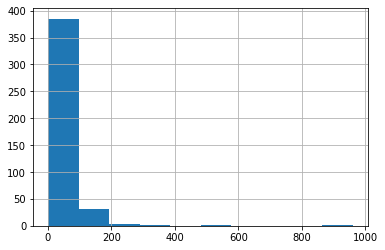

In [ ]:
#target(등록차량수) 분포확인
#분포를 확인하는 것은 타겟변수가 정상적인 데이터라는 것, 정규분포를 띨때 정확도가 올라감
new_train['등록차량수'].hist()

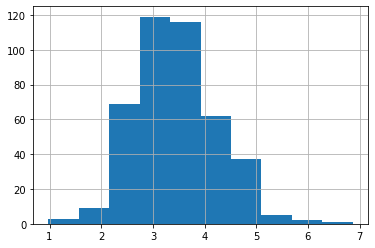

In [ ]:
np.log1p(new_train['등록차량수']).hist()

- 로그변환후 타겟변수가 더 정규분포에 가까워진것을 확인할 수 있음  
  따라서 타겟변수에 로그변환을 적용
  나머지 변수에도 동일하게 적용

In [ ]:
#타겟변수 이후의 것도 확인 - train
skew_features = new_train[features_index_unobject].apply(lambda x: skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

등록차량수                           8.549042
도보 10분거리 내 지하철역 수(환승노선 수 반영)    3.563665
전용면적별세대수                        3.193718
도보 10분거리 내 버스정류장 수              2.789813
단지내주차면수                         1.720645
총세대수                            1.344617
전용면적                            1.225169
dtype: float64


In [ ]:
# 타겟변수 이후의 것도 확인 - test
skew_features = new_test[[col for col in features_index_unobject if col != '등록차량수']].apply(lambda x: skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

도보 10분거리 내 지하철역 수(환승노선 수 반영)    4.037509
도보 10분거리 내 버스정류장 수              2.165797
전용면적별세대수                        1.309366
총세대수                            1.246403
단지내주차면수                         1.128265
전용면적                            1.093880
dtype: float64


- 보통 1이상의 왜곡이 있을때 높다고 판단, 1이상인 컬럼에 대해서 로그처리 진행

In [ ]:
new_train[features_index_unobject] = np.log1p(new_train[features_index_unobject])
new_test[[col for col in features_index_unobject if col != '등록차량수']] = np.log1p(new_test[[col for col in features_index_unobject if col != '등록차량수']])

- train 데이터에서는 변환하지 않았던 도보 컬럼이 추가됨 train도 적용

In [ ]:
new_train.drop('단지코드', axis=1, inplace=True)

In [ ]:
new_test.drop('단지코드', axis=1, inplace=True)

## 데이터 분할

In [ ]:
y_target = new_train.등록차량수
X_features = new_train.drop('등록차량수', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state=1001)

ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]} 

# 모델 생성

In [ ]:
def get_mae(model):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test , pred)
    return mae

def get_maes(models):
    maes = [ ]
    for model in models:
        mae = get_mae(model)
        maes.append(mae)
    return maes

In [ ]:
# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_maes(models)

[0.11345691686106178, 0.11213718761448954, 0.6442978307057464]

In [ ]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

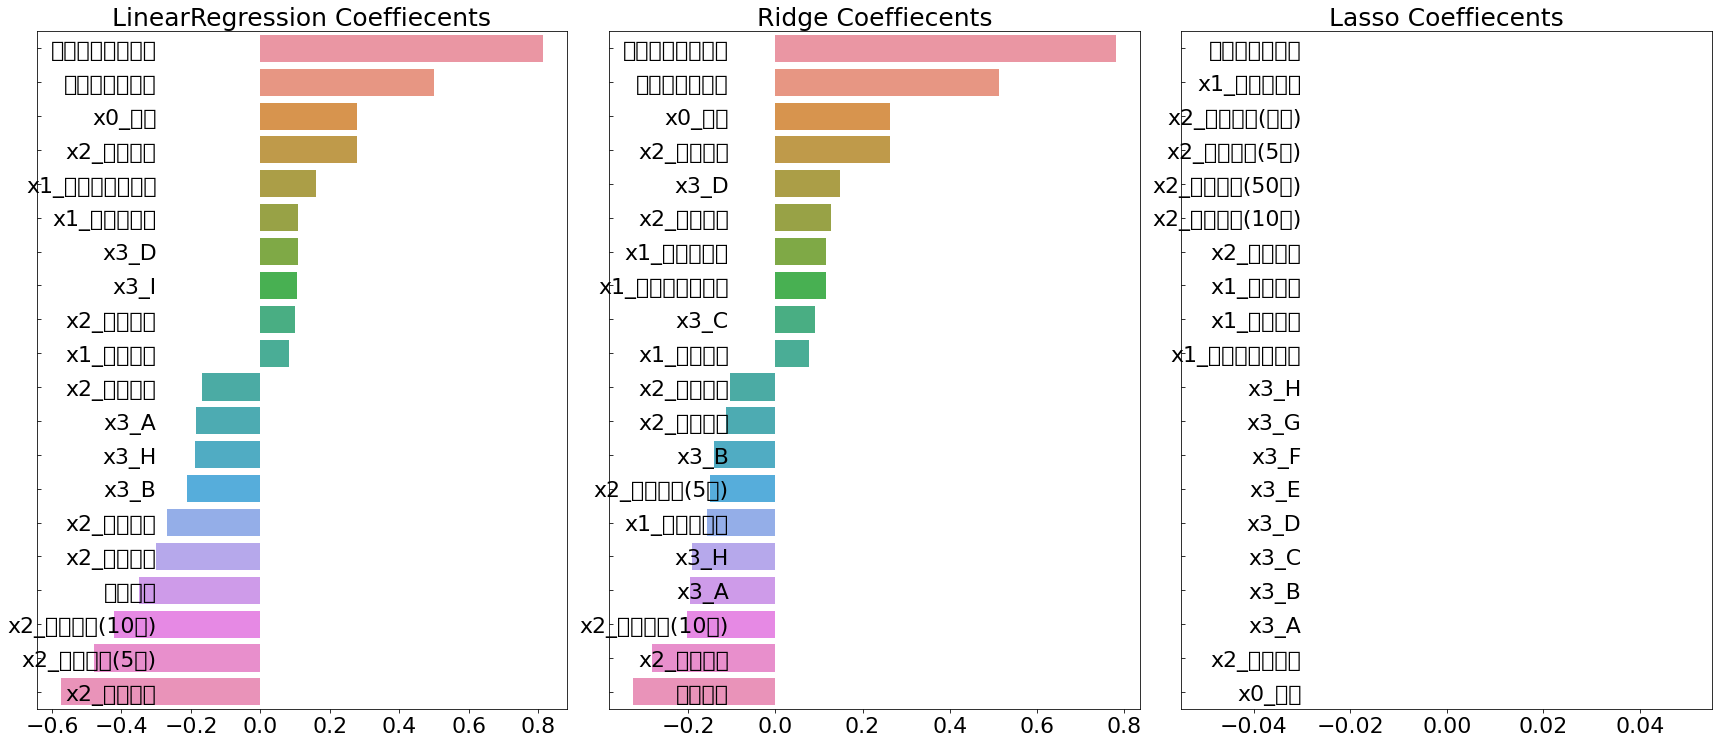

In [ ]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [ ]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    mae = -1 * grid_model.best_score_
    print('{0} 5 CV 시 최적 평균 MAE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(mae, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 MAE 값: 0.0316, 최적 alpha:{'alpha': 1}
Lasso 5 CV 시 최적 평균 MAE 값: 0.0307, 최적 alpha:{'alpha': 0.001}


In [ ]:
def evaluate_regr(model, y):
    # MSE 는 scikit learn의 mean_absolute_error() 로 계산
    pred = model.predict(X_test)
    mse_val = mean_absolute_error(y,pred)
    print('MAE: {0:.3F}'.format(mse_val))

In [ ]:
evaluate_regr(best_rige, y_test)

MAE: 0.094


In [ ]:
np.exp(best_rige.predict(new_test))

array([ 15.01159788,  18.61141351,  51.89049466,  24.14027217,
         3.17015967,  26.46787875, 166.49480947,  18.61368065,
        46.15997895,  28.4683944 ,  15.3001884 ,  24.25071901,
        16.98077289,  25.7727889 ,   6.78740215,  41.27074594,
        32.80312295, 170.01175297,  33.25243929,  85.89979832,
         9.01124338,  30.19375541,  43.49081902,  25.53751602,
        21.3385947 ,  42.09750555,  41.91338022,  38.67398811,
        39.89644739,  10.05089541,  33.30768872,  24.76087657,
       119.7991869 ,  33.20961801,  13.04052831,  50.95865151,
        20.29254157,  12.39252843,  27.59198142,  18.83358415,
        27.12930169,  29.16852722,  33.16164061,  27.98603117,
        13.34269192, 111.71194059,  32.87502295,  16.17546287,
       130.78451446,  69.11136567,  83.07440315,  28.01260053,
         6.88611741,  24.64423191,  10.27031007,  93.02128448,
        33.54876307,  20.72913353,  50.28035996, 141.22810695,
        80.22071992,  20.04466488,  11.76342733,  29.40